In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pylab
from tqdm import trange
import scipy
import statistics
import scipy.stats as stats
from scipy.stats import bernoulli

In [3]:
def is_consensus(x, fix):
    res = True
    count = 0
    for i in range(1, len(x)):
        if x[i-1] != x[i]:
            count += 1
    if count > 2:
        res = False
    return res
def clusters(x0,eps2, fix = {}):
    count = [x0[0]]
    l=0
    for i in range(1,len(x0)):
        if i not in fix:
            for j in range (len(count)):
                if np.abs(x0[i] - count[j])<eps2:
                    l+=1
            if l==0:
                count.append(x0[i])
            l=0
    return np.array(count)

def compare (x ,y, eps):
    result = 1
    for k in range(len(x)):
        if abs(x[k] - y[k]) >= eps:
            result = 0
    return bool(result)

def insert_agent(x, ind):
    if  ind != 0:
        opinion = (x[ind]+x[ind-1])/2
    else:
        opinion = x[ind]
    _X = np.insert(x,ind,opinion)
    return _X

def new_op(x, i, eps):
    count = 1
    summ = x[i]
    for k in range(len(x)):
        if (abs(x[i] - x[k]) < eps) and (i != k):
            #print(i, j, x[i], x[j])
            summ += x[k]
            count += 1
    #print(summ, count)
    return summ/count

def pair_count (x0, fix = {}):
    count = [0, 0]
    for i in range(len(x0)):
        if i not in fix:
            if x0[i] >= 0.5:
                count[0] += 1
            else:
                count[1] += 1
    #count[0] = count[0]/len(x0)
    #count[1] = count[1] / len(x0)
    return count

def Hen_Kr (x0, eps, eps2,fix, v):
    X = [np.array(x0)]
    t = 0
    while True:
        X.append(np.zeros(len(x0)))
        t += 1
        for j in range(len(x0)):
            if j not in fix:
                X[t][j] = new_op(X[t - 1], j, eps)
            else:
                if X[t - 1][j] + v <= 1:
                    X[t][j] = X[t - 1][j] + v
                else:
                    X[t][j] = 1
        if compare(X[t], X[t - 1], eps2):
            break
    return X, t

def find_fix(x0):
    diff = 1
    ind = 0
    for j in range (len(x0)):
        if (x0[j] - 0.5 < diff) and (x0[j] - 0.5 >= 0):
            ind = j
            diff = abs(0.5 - x0[j])
    return ind

In [4]:
def Hen_Kr_actm2_statistics (x0, eps, eps2,fix, v, prob):
    X = [np.array(x0)]
    t = 0
    consensus_value = 0
    consensus_time = 0
    consensus_flag = True
    pos0_6_time = 0
    pos0_6_flag = True
    while True:
        X.append(np.zeros(len(x0)))
        active_mask = bernoulli.rvs(p=prob, size=n)
        t += 1
        for j in range(len(x0)):
            if j not in fix and active_mask[j]==1:
                X_prev = np.copy(X[t -1])
                X_prev[active_mask==0]=0-2*eps - 2*eps2 
                X[t][j] = new_op(X_prev, j, eps)
                X[t][active_mask==0]=X[t-1][active_mask==0]
            else:
                if X[t - 1][j] + v <= 1:
                    X[t][j] = X[t - 1][j] + v
                else:
                    X[t][j] = 1
        if consensus_flag:
            ctrs = clusters(X[t],eps,fix_control)
            if len(ctrs) ==1:
                consensus_flag = False
                consensus_time = t
                consensus_value = X[t][0]
        if pos0_6_flag and np.all(X[t]>= 0.6):
            pos0_6_time = t
            pos0_6_flag = False
        if compare(X[t], X[t - 1], eps2):
            break
    return X, t, consensus_value, consensus_time, pos0_6_time

In [5]:
prob=0.5

fix_control = set({})
v_c = 0

In [5]:
count_experiments = 50000
#eps = 1.0
ee = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
eps2 = 0.001
n = 10
p = 0.5

for eps in ee:
    cons_value_data = np.asarray([])
    cons_time_data = np.asarray([])
    positive_time_data = np.asarray([])
    stop_time_data = np.asarray([])

    cluster_numbers = np.zeros(n)
    cluster_numbers_c = np.zeros(n)


    #cl_rs = np.zeros(n, dtype=object)
    cl_rs = np.zeros(n, dtype=list)
    cl_rs_c = np.zeros(n, dtype=list)

    for i in trange(count_experiments):

        x0 = np.random.sample(n)
        x0.sort()

        Xc, tc = Hen_Kr(x0,eps,eps2,fix_control, v_c)
        ccltrs = clusters(Xc[tc],eps,fix_control)

        X, t, _, _, _ = Hen_Kr_actm2_statistics(x0, eps, eps2, fix_control,v_c, prob)
        cltrs = clusters(X[t],eps,fix_control)

        cluster_numbers[len(cltrs)-1] +=1
        cluster_numbers_c[len(ccltrs)-1] +=1

        cl_rs[len(cltrs)-1] = np.append(cl_rs[len(cltrs)-1], cltrs)
        cl_rs_c[len(ccltrs)-1] = np.append(cl_rs_c[len(ccltrs)-1], ccltrs)


    print('STHK:\n',cluster_numbers[:6], np.sum(cluster_numbers[:6]), '\nHK:\n', cluster_numbers_c[:6], np.sum(cluster_numbers_c[:6]) )

    np.save(f'data/cln{eps}_{n}.npy', cluster_numbers)
    np.save(f'data/con{eps}_{n}.npy', cl_rs[0])

    np.save(f'data/ccln{eps}_{n}.npy', cluster_numbers_c)
    np.save(f'data/ccon{eps}_{n}.npy', cl_rs_c[0])

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:46<00:00, 1068.32it/s]


STHK:
 [4.0000e+00 2.3000e+02 3.3760e+03 1.3669e+04 2.0412e+04 1.0676e+04] 48367.0 
HK:
 [1.5000e+01 1.3400e+03 1.0027e+04 2.0314e+04 1.4078e+04 3.8510e+03] 49625.0


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:02<00:00, 794.67it/s]


STHK:
 [  611. 13604. 25872.  9552.   361.     0.] 50000.0 
HK:
 [ 3261. 31829. 14380.   530.     0.     0.] 50000.0


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:17<00:00, 648.13it/s]


STHK:
 [ 9474. 31828.  8642.    56.     0.     0.] 50000.0 
HK:
 [25709. 24055.   236.     0.     0.     0.] 50000.0


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:22<00:00, 604.60it/s]


STHK:
 [28303. 20679.  1018.     0.     0.     0.] 50000.0 
HK:
 [44729.  5271.     0.     0.     0.     0.] 50000.0


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:27<00:00, 571.53it/s]


STHK:
 [40881.  9119.     0.     0.     0.     0.] 50000.0 
HK:
 [49435.   565.     0.     0.     0.     0.] 50000.0


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:35<00:00, 525.29it/s]


STHK:
 [46242.  3758.     0.     0.     0.     0.] 50000.0 
HK:
 [4.9954e+04 4.6000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00] 50000.0


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:38<00:00, 506.27it/s]


STHK:
 [48301.  1699.     0.     0.     0.     0.] 50000.0 
HK:
 [4.9999e+04 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00] 50000.0


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:31<00:00, 545.27it/s]


STHK:
 [49084.   916.     0.     0.     0.     0.] 50000.0 
HK:
 [50000.     0.     0.     0.     0.     0.] 50000.0


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:31<00:00, 545.20it/s]


STHK:
 [49647.   353.     0.     0.     0.     0.] 50000.0 
HK:
 [50000.     0.     0.     0.     0.     0.] 50000.0


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:28<00:00, 563.77it/s]

STHK:
 [50000.     0.     0.     0.     0.     0.] 50000.0 
HK:
 [50000.     0.     0.     0.     0.     0.] 50000.0


In [32]:
np.save(f'data/cln{eps}_{n}.npy', cluster_numbers)
np.save(f'data/con{eps}_{n}.npy', cl_rs[0])

np.save(f'data/ccln{eps}_{n}.npy', cluster_numbers_c)
np.save(f'data/ccon{eps}_{n}.npy', cl_rs_c[0])

### Распределения

STHK
[0.22497758 0.15184017 0.10504888 0.10167154 0.10424505 0.10949767
 0.11490454 0.12044038 0.12740522 0.13156552]
HK
[0.1817329  0.12279339 0.09776693 0.09803974 0.09738047 0.0957978
 0.09507116 0.09319007 0.09162067 0.09144382]


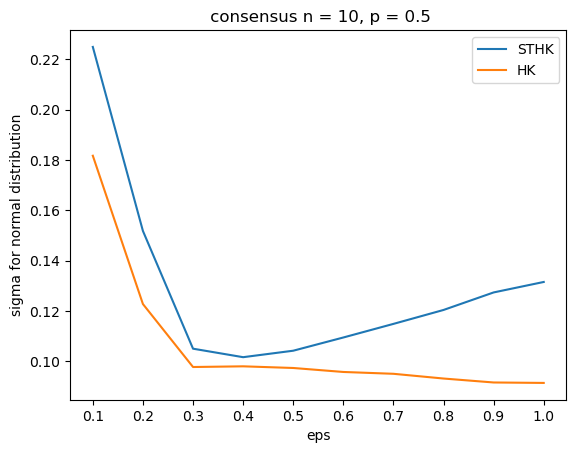

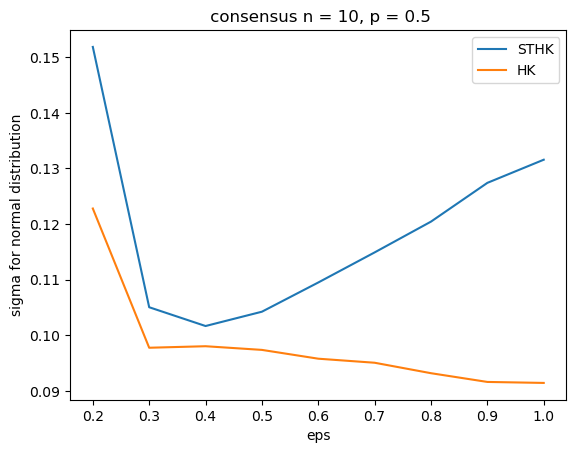

In [6]:
ee = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
clv10 = [np.load(f'data/con{ee[i]}_10.npy', mmap_mode = 'r') for i in range(len(ee))]
cclv10 = [np.load(f'data/ccon{ee[i]}_10.npy', mmap_mode = 'r') for i in range(len(ee))]

sigmas=np.array([np.std(clv10[i]) for i in range(len(ee))])

sigmac=np.array([np.std(cclv10[i]) for i in range(len(ee))])

print('STHK', sigmas, 'HK', sigmac, sep='\n')

plt.plot(ee, sigmas, label='STHK')
plt.plot(ee, sigmac, label='HK')
plt.xticks(ee)
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus n = 10, p = 0.5')
plt.legend()

plt.show()

plt.plot(ee[1:], sigmas[1:], label='STHK')
plt.plot(ee[1:], sigmac[1:], label='HK')
plt.xticks(ee[1:])
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus n = 10, p = 0.5')
plt.legend()

plt.show()

STHK
[0.         0.08151242 0.06890965 0.07001615 0.07038099 0.0696692
 0.06865013 0.06839905 0.06879763 0.06939827]
HK
[0.         0.0730422  0.07212163 0.07195526 0.07019963 0.06869132
 0.06758869 0.06610802 0.06484761 0.0647429 ]


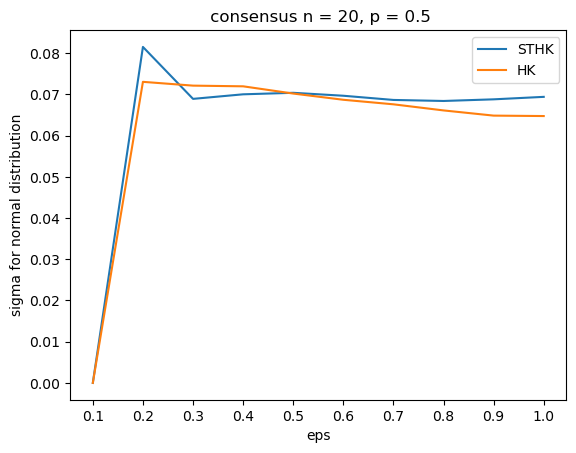

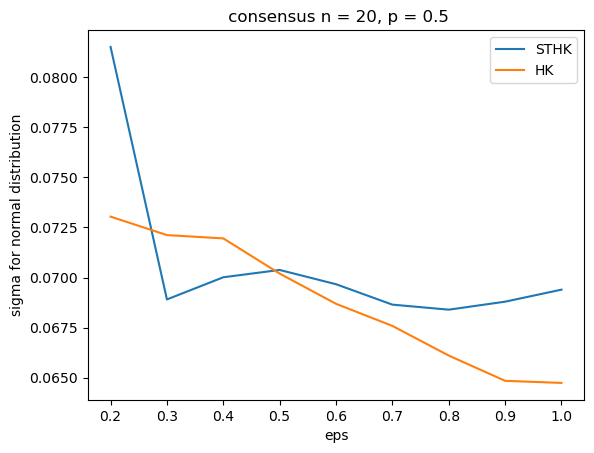

In [7]:
ee = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
clv20 = [np.load(f'data/con{ee[i]}_20.npy', mmap_mode = 'r') for i in range(len(ee))]
cclv20 = [np.load(f'data/ccon{ee[i]}_20.npy', mmap_mode = 'r') for i in range(len(ee))]

sigmas=np.array([np.std(clv20[i]) for i in range(len(ee))])

sigmac=np.array([np.std(cclv20[i]) for i in range(len(ee))])

print('STHK', sigmas, 'HK', sigmac, sep='\n')

plt.plot(ee, sigmas, label='STHK')
plt.plot(ee, sigmac, label='HK')
plt.xticks(ee)
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus n = 20, p = 0.5')
plt.legend()

plt.show()

plt.plot(ee[1:], sigmas[1:], label='STHK')
plt.plot(ee[1:], sigmac[1:], label='HK')
plt.xticks(ee[1:])
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus n = 20, p = 0.5')
plt.legend()

plt.show()

STHK
[0.         0.06091913 0.05826793 0.05971779 0.0582662  0.05646471
 0.05501118 0.05465856 0.05422574 0.05415724]
HK
[0.         0.05997818 0.06046187 0.05984688 0.05747481 0.0561752
 0.05532055 0.05443488 0.05331765 0.05286232]


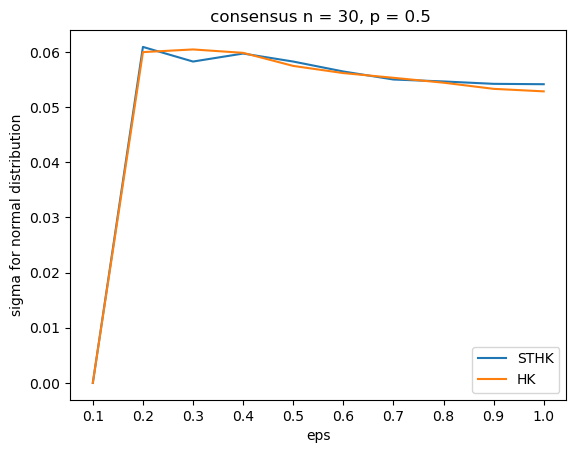

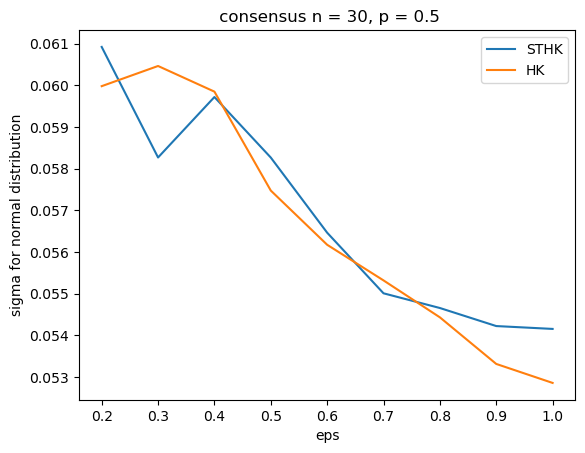

In [8]:
ee = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
clv30 = [np.load(f'data/con{ee[i]}_30.npy', mmap_mode = 'r') for i in range(len(ee))]
cclv30 = [np.load(f'data/ccon{ee[i]}_30.npy', mmap_mode = 'r') for i in range(len(ee))]

sigmas=np.array([np.std(clv30[i]) for i in range(len(ee))])

sigmac=np.array([np.std(cclv30[i]) for i in range(len(ee))])

print('STHK', sigmas, 'HK', sigmac, sep='\n')

plt.plot(ee, sigmas, label='STHK')
plt.plot(ee, sigmac, label='HK')
plt.xticks(ee)
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus n = 30, p = 0.5')
plt.legend()

plt.show()

plt.plot(ee[1:], sigmas[1:], label='STHK')
plt.plot(ee[1:], sigmac[1:], label='HK')
plt.xticks(ee[1:])
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus n = 30, p = 0.5')
plt.legend()

plt.show()

STHK
[0.         0.05264695 0.05253101 0.05241895 0.0507987  0.04930181
 0.04783978 0.0467967  0.04681386 0.04681007]
HK
[0.         0.05379509 0.0533495  0.05207828 0.04961736 0.04895918
 0.04796594 0.04679772 0.0462205  0.04600932]


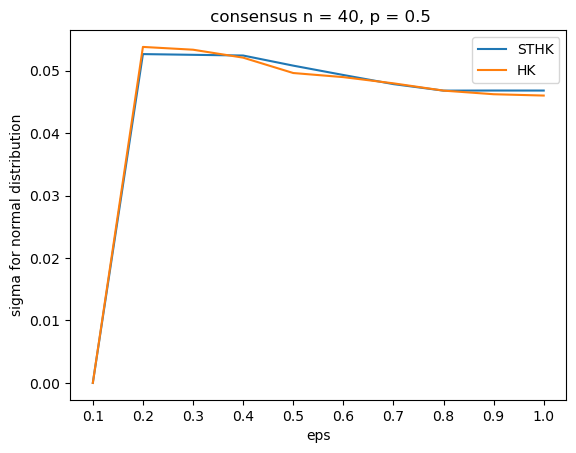

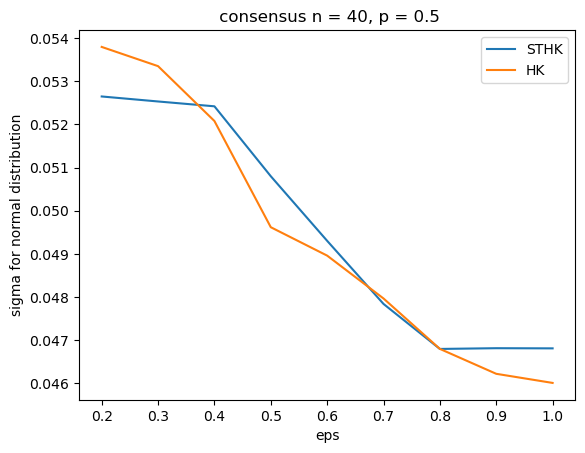

In [9]:
ee = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
clv40 = [np.load(f'data/con{ee[i]}_40.npy', mmap_mode = 'r') for i in range(len(ee))]
cclv40 = [np.load(f'data/ccon{ee[i]}_40.npy', mmap_mode = 'r') for i in range(len(ee))]

sigmas=np.array([np.std(clv40[i]) for i in range(len(ee))])

sigmac=np.array([np.std(cclv40[i]) for i in range(len(ee))])

print('STHK', sigmas, 'HK', sigmac, sep='\n')

plt.plot(ee, sigmas, label='STHK')
plt.plot(ee, sigmac, label='HK')
plt.xticks(ee)
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus n = 40, p = 0.5')
plt.legend()

plt.show()

plt.plot(ee[1:], sigmas[1:], label='STHK')
plt.plot(ee[1:], sigmac[1:], label='HK')
plt.xticks(ee[1:])
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus n = 40, p = 0.5')
plt.legend()

plt.show()

STHK
[0.         0.04857759 0.04851635 0.04729385 0.04591977 0.04407027
 0.04302301 0.04210111 0.04161105 0.04139113]
HK
[0.         0.04847052 0.04848195 0.04660681 0.04440211 0.04379631
 0.04311334 0.04198727 0.04134907 0.04085551]


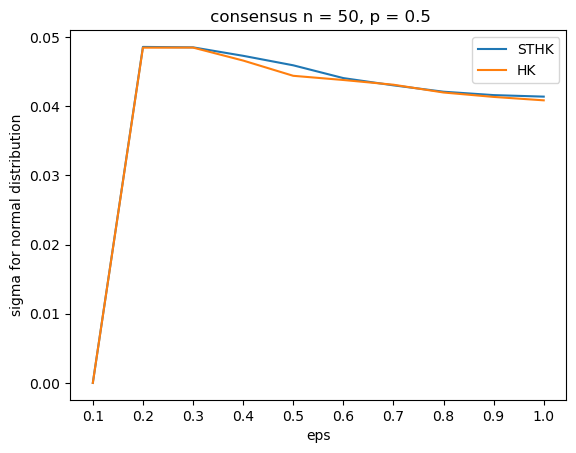

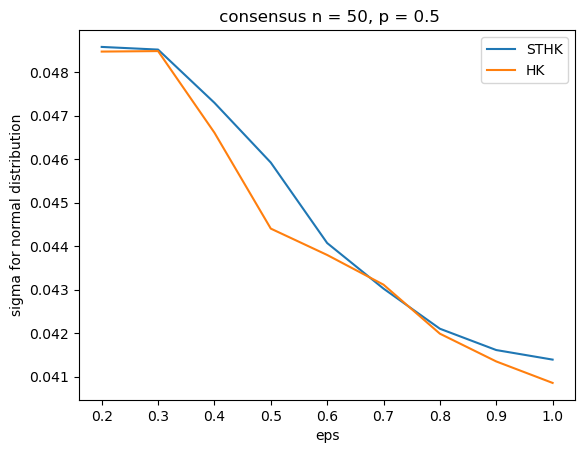

In [10]:
ee = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
clv50 = [np.load(f'data/con{ee[i]}_50.npy', mmap_mode = 'r') for i in range(len(ee))]
cclv50 = [np.load(f'data/ccon{ee[i]}_50.npy', mmap_mode = 'r') for i in range(len(ee))]

sigmas=np.array([np.std(clv50[i]) for i in range(len(ee))])

sigmac=np.array([np.std(cclv50[i]) for i in range(len(ee))])

print('STHK', sigmas, 'HK', sigmac, sep='\n')

plt.plot(ee, sigmas, label='STHK')
plt.plot(ee, sigmac, label='HK')
plt.xticks(ee)
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus n = 50, p = 0.5')
plt.legend()

plt.show()

plt.plot(ee[1:], sigmas[1:], label='STHK')
plt.plot(ee[1:], sigmac[1:], label='HK')
plt.xticks(ee[1:])
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus n = 50, p = 0.5')
plt.legend()

plt.show()

STHK
[0.         0.04407793 0.04504236 0.04319286 0.04239571 0.04019677
 0.03940407 0.03850469 0.0381456  0.0380015 ]
HK
[0.         0.04470145 0.04475395 0.04239643 0.04064949 0.03997427
 0.03934483 0.03838307 0.03773446 0.03743984]


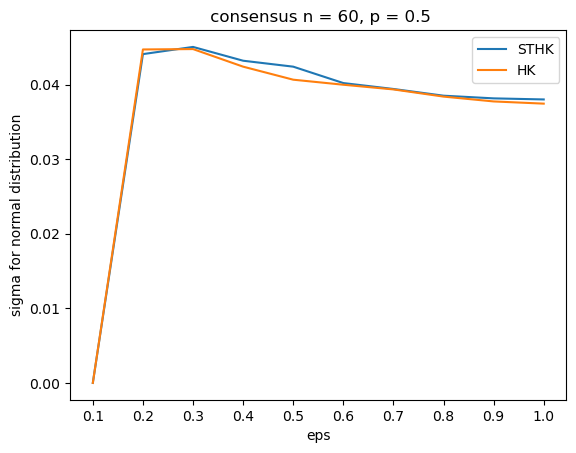

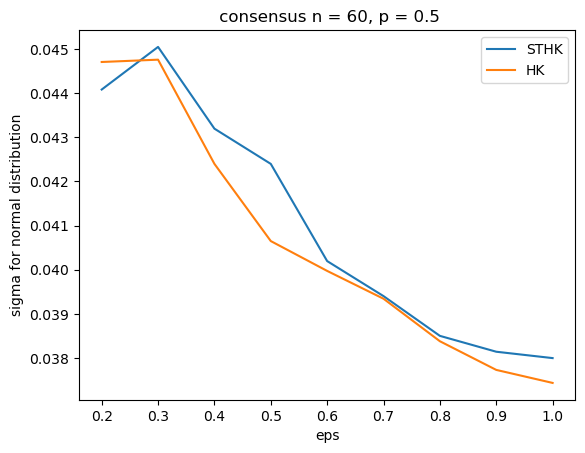

In [14]:
ee = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
clv60 = [np.load(f'data/con{ee[i]}_60.npy', mmap_mode = 'r') for i in range(len(ee))]
cclv60 = [np.load(f'data/ccon{ee[i]}_60.npy', mmap_mode = 'r') for i in range(len(ee))]

sigmas=np.array([np.std(clv60[i]) for i in range(len(ee))])

sigmac=np.array([np.std(cclv60[i]) for i in range(len(ee))])

print('STHK', sigmas, 'HK', sigmac, sep='\n')

plt.plot(ee, sigmas, label='STHK')
plt.plot(ee, sigmac, label='HK')
plt.xticks(ee)
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus n = 60, p = 0.5')
plt.legend()

plt.show()

plt.plot(ee[1:], sigmas[1:], label='STHK')
plt.plot(ee[1:], sigmac[1:], label='HK')
plt.xticks(ee[1:])
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus n = 60, p = 0.5')
plt.legend()

plt.show()

STHK
[0.         0.0407368  0.04255951 0.04025218 0.03900662 0.03734221
 0.03634124 0.03573703 0.03510109 0.03519077]
HK
[0.         0.04128938 0.04194779 0.03938714 0.03728182 0.03706754
 0.03652385 0.03562447 0.0349072  0.03451091]


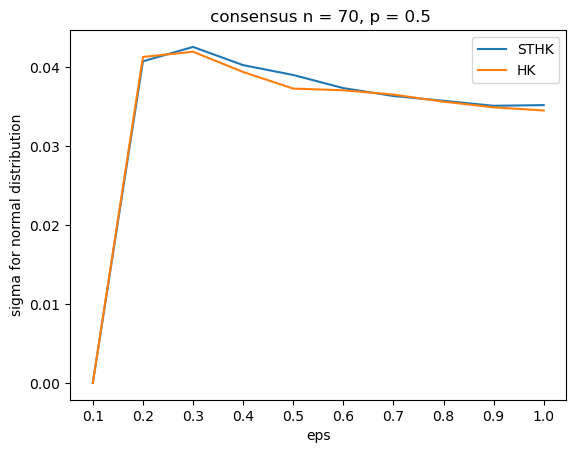

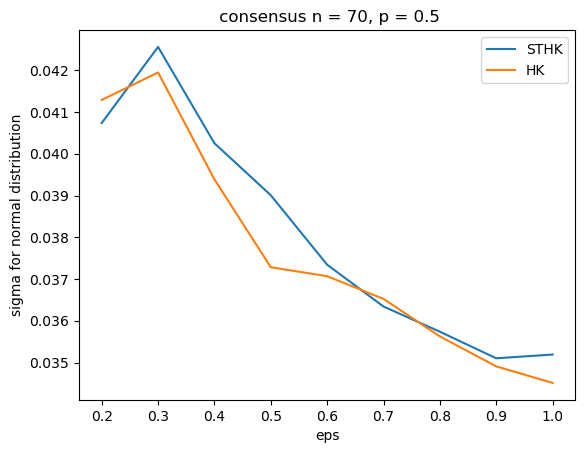

In [11]:
ee = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
clv70 = [np.load(f'data/con{ee[i]}_70.npy', mmap_mode = 'r') for i in range(len(ee))]
cclv70 = [np.load(f'data/ccon{ee[i]}_70.npy', mmap_mode = 'r') for i in range(len(ee))]

sigmas=np.array([np.std(clv70[i]) for i in range(len(ee))])

sigmac=np.array([np.std(cclv70[i]) for i in range(len(ee))])

print('STHK', sigmas, 'HK', sigmac, sep='\n')

plt.plot(ee, sigmas, label='STHK')
plt.plot(ee, sigmac, label='HK')
plt.xticks(ee)
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus n = 70, p = 0.5')
plt.legend()

plt.show()

plt.plot(ee[1:], sigmas[1:], label='STHK')
plt.plot(ee[1:], sigmac[1:], label='HK')
plt.xticks(ee[1:])
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus n = 70, p = 0.5')
plt.legend()

plt.show()

In [12]:
ee = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
nn = [10, 20, 30, 40, 50, 60, 70]

clv = [[np.load(f'data/con{ee[i]}_{nn[j]}.npy', mmap_mode = 'r') for i in range(len(ee))] for j in range(len(nn))]
cclv = [[np.load(f'data/ccon{ee[i]}_{nn[j]}.npy', mmap_mode = 'r') for i in range(len(ee))] for j in range(len(nn))]

sigma = np.array([np.array([np.std(clv[j][i]) for i in range(len(ee))]) for j in range(len(nn))])
sigmac = np.array([np.array([np.std(cclv[j][i]) for i in range(len(ee))]) for j in range(len(nn))])

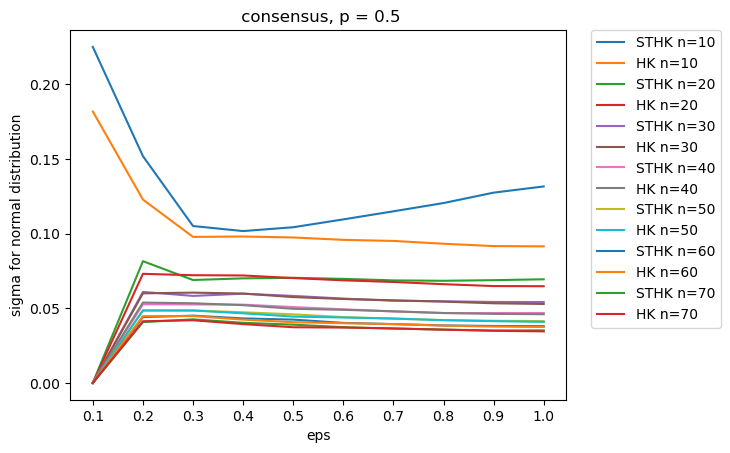

In [13]:
for j in range(len(nn)):
    plt.plot(ee, sigma[j], label=f'STHK n={nn[j]}')
    plt.plot(ee, sigmac[j], label=f'HK n={nn[j]}')
plt.xticks(ee)
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus, p = 0.5')
plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)

plt.show()

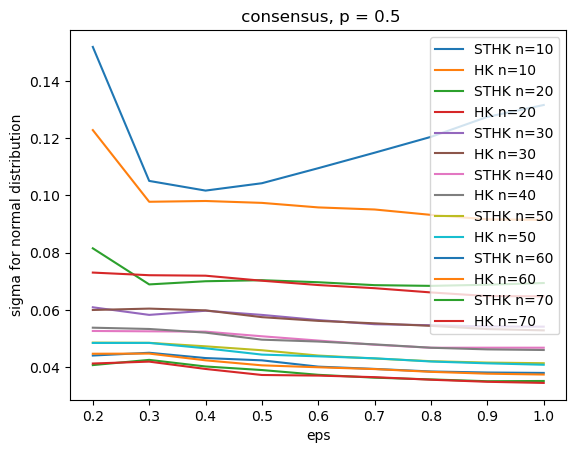

In [14]:
for j in range(len(nn)):
    plt.plot(ee[1:], sigma[j][1:], label=f'STHK n={nn[j]}')
    plt.plot(ee[1:], sigmac[j][1:], label=f'HK n={nn[j]}')

plt.xticks(ee[1:])
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus, p = 0.5')
plt.legend()

plt.show()

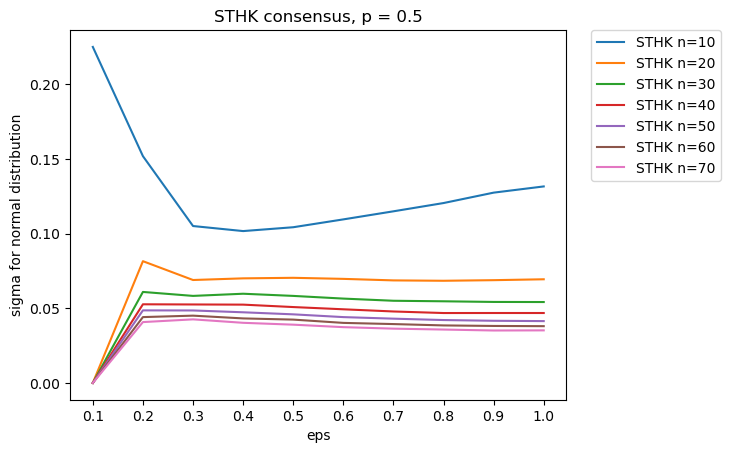

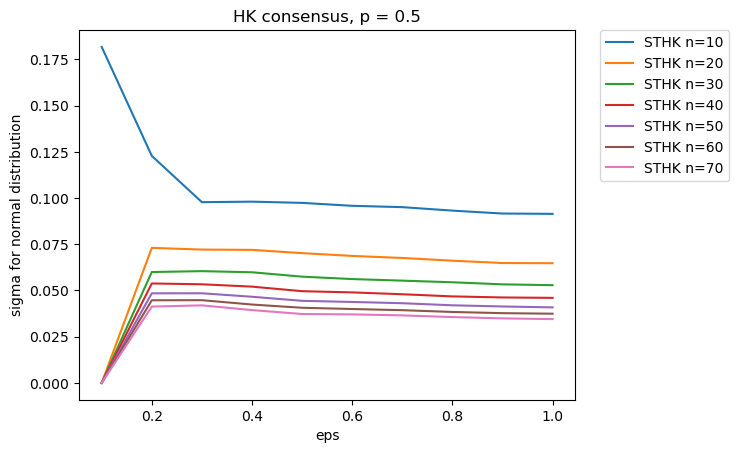

In [15]:
for j in range(len(nn)):
    plt.plot(ee, sigma[j], label=f'STHK n={nn[j]}')

plt.xticks(ee)
plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f'STHK consensus, p = 0.5')
plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)
plt.show()

for j in range(len(nn)):
    plt.plot(ee, sigmac[j], label=f'STHK n={nn[j]}')

plt.xlabel('eps')
plt.ylabel('sigma for normal distribution')
plt.title(f'HK consensus, p = 0.5')
plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)

plt.show()

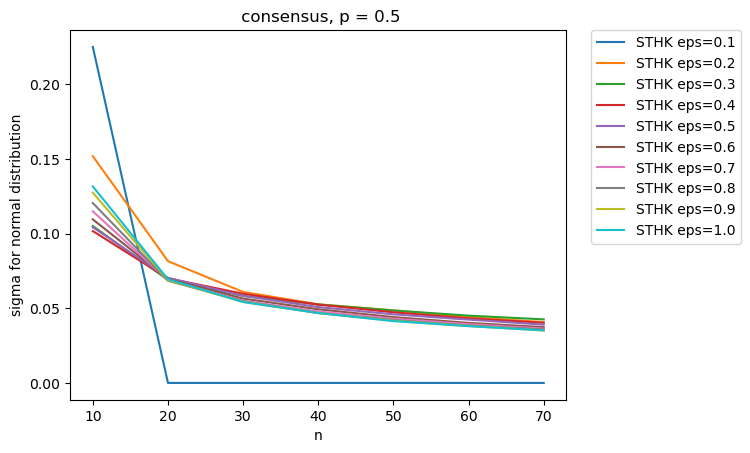

In [16]:
for i in range(len(ee)):
    plt.plot(nn, sigma[:,i], label=f'STHK eps={ee[i]}')
#plt.xticks(nn)
plt.xlabel('n')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus, p = 0.5')

plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)
plt.show()

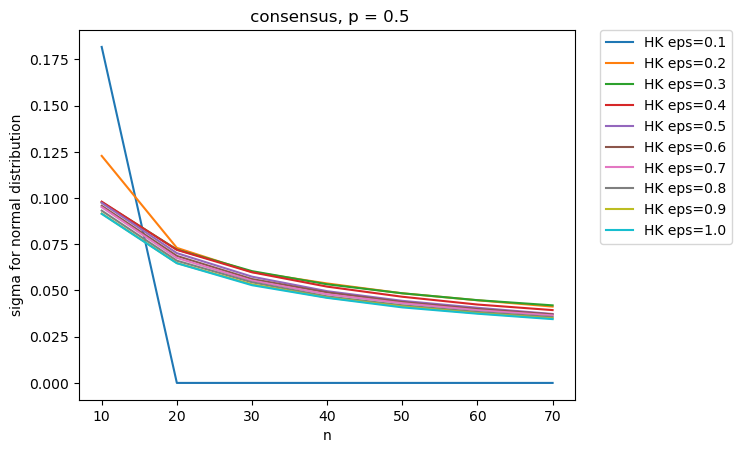

In [17]:
for i in range(len(ee)):
    plt.plot(nn, sigmac[:,i], label=f'HK eps={ee[i]}')
#plt.xticks(nn)
plt.xlabel('n')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus, p = 0.5')

plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)
plt.show()

In [55]:
sigma[:, 1], sigmasn2

(array([0.14770675, 0.08151242, 0.06091913, 0.05264695, 0.04857759,
        0.04407793, 0.0407368 ]),
 array([0.14770675, 0.08151242, 0.06091913, 0.05264695, 0.04857759,
        0.04407793, 0.0407368 ]))

STHK
[0.22497758 0.         0.         0.         0.         0.
 0.        ]
HK
[0.1817329 0.        0.        0.        0.        0.        0.       ]


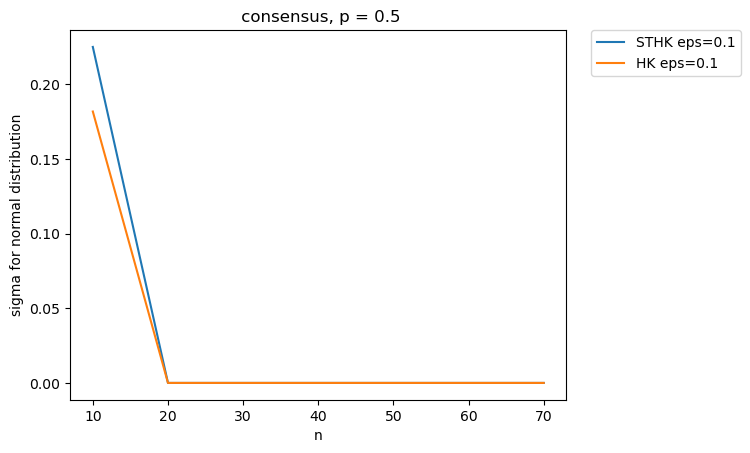

In [18]:
nn = [10, 20, 30, 40, 50, 60, 70]

nclv01 = [np.load(f'data/con0.1_{nn[i]}.npy', mmap_mode = 'r') for i in range(len(nn))]
ncclv01 = [np.load(f'data/ccon0.1_{nn[i]}.npy', mmap_mode = 'r') for i in range(len(nn))]

nclv02 = [np.load(f'data/con0.2_{nn[i]}.npy', mmap_mode = 'r') for i in range(len(nn))]
ncclv02 = [np.load(f'data/ccon0.2_{nn[i]}.npy', mmap_mode = 'r') for i in range(len(nn))]

sigmasn1=np.array([np.std(nclv01[i]) for i in range(len(nn))])
sigmacn1=np.array([np.std(ncclv01[i]) for i in range(len(nn))])

sigmasn2=np.array([np.std(nclv02[i]) for i in range(len(nn))])

print('STHK', sigmasn1, 'HK', sigmacn1, sep='\n')

plt.plot(nn, sigmasn1, label='STHK eps=0.1')
plt.plot(nn, sigmacn1, label='HK eps=0.1')

plt.xticks(nn)
plt.xlabel('n')
plt.ylabel('sigma for normal distribution')
plt.title(f' consensus, p = 0.5')

plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)
plt.show()

In [19]:
cln0250 = np.load('data/cln0.2_50.npy', mmap_mode = 'r')
clv0250 = np.load('data/con0.2_50.npy', mmap_mode = 'r')
clv0250 = clv0250[1:]

ccln0250 = np.load('data/ccln0.2_50.npy', mmap_mode = 'r')
cclv0250 = np.load('data/ccon0.2_50.npy', mmap_mode = 'r')
cclv0250 = cclv0250[1:]


In [16]:
#nn = [10, 20, 30, 40, 50, 60, 70]
fix_control = set({})
v_c = 0
count_experiments = 50000
#eps = 1.0
ee = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
eps2 = 0.001
n = 20
pp = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

for eps in ee:
    print(f"{eps}:\n")
    cluster_numbers = np.zeros((pp.shape[0],n))
    cluster_numbers_c = np.zeros(n)

    cl_rs = np.zeros((pp.shape[0], n), dtype=list)
    cl_rs_c = np.zeros(n, dtype=list)

    for i in trange(count_experiments):

        x0 = np.random.sample(n)
        x0.sort()

        Xc, tc = Hen_Kr(x0,eps,eps2,fix_control, v_c)
        ccltrs = clusters(Xc[tc],eps2,fix_control)
        
        cluster_numbers_c[len(ccltrs)-1] +=1
        
        cl_rs_c[len(ccltrs)-1] = np.append(cl_rs_c[len(ccltrs)-1], ccltrs)
        for k in range(pp.shape[0]):
            prob = pp[k]
            X, t, _, _, _ = Hen_Kr_actm2_statistics(x0, eps, eps2, fix_control,v_c, prob)
            cltrs = clusters(X[t],eps2,fix_control)
            cluster_numbers[k,len(cltrs)-1] +=1
            cl_rs[k,len(cltrs)-1] = np.append(cl_rs[k,len(cltrs)-1], cltrs)
            if ((len(cltrs)==1) and ((cltrs[0] - 0)<0.005)):
                t_list = np.linspace(0, t, t + 1)
                t_c_list = np.linspace(0, tc, tc + 1)
                fig = plt.figure(facecolor='white', figsize=(9, 12))

                ax = fig.add_subplot(211)
                ax.plot(t_list, X, linewidth=2)

                ax2 = fig.add_subplot(212)
                ax2.plot(t_c_list, Xc, linewidth=2)

                ax.title.set_text(f'STHK n={n}, eps={eps}, p={prob}, clrs={cltrs}')
                ax2.title.set_text(f'HK n={n}, eps={eps}, clrs={ccltrs}')

                ax.set_xlabel('t')
                ax.set_ylabel('Value')
                ax2.set_xlabel('t')
                ax2.set_ylabel('Value')

                plt.show()
                
        
    print('STHK:\n',cluster_numbers[:6], np.sum(cluster_numbers[:6]), '\nHK:\n', cluster_numbers_c[:6], np.sum(cluster_numbers_c[:6]) )

    np.save(f'data/pcln{eps}_{n}.npy', cluster_numbers)
    np.save(f'data/pcon{eps}_{n}.npy', cl_rs[:,0])

    np.save(f'data/pccln{eps}_{n}.npy', cluster_numbers_c)
    np.save(f'data/pccon{eps}_{n}.npy', cl_rs_c[0])

0.1:



100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [14:54<00:00, 55.88it/s]


STHK:
 [[0.0000e+00 6.0000e+00 4.1400e+02 2.8190e+03 7.4910e+03 1.0204e+04
  9.8010e+03 7.0620e+03 4.6670e+03 2.7950e+03 1.6430e+03 1.0060e+03
  7.3900e+02 4.6100e+02 2.8600e+02 1.9700e+02 9.9000e+01 9.8000e+01
  1.0100e+02 1.1100e+02]
 [0.0000e+00 2.6000e+01 1.1360e+03 7.1890e+03 1.3709e+04 1.3110e+04
  8.0380e+03 3.7510e+03 1.5890e+03 7.7800e+02 3.3300e+02 1.4300e+02
  8.9000e+01 3.5000e+01 2.6000e+01 1.6000e+01 8.0000e+00 1.0000e+01
  4.0000e+00 1.0000e+01]
 [0.0000e+00 4.7000e+01 2.1880e+03 1.1960e+04 1.7711e+04 1.1658e+04
  4.4760e+03 1.3180e+03 4.1200e+02 1.4200e+02 6.0000e+01 1.5000e+01
  9.0000e+00 2.0000e+00 2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [0.0000e+00 1.0500e+02 3.7290e+03 1.6783e+04 1.8773e+04 8.1700e+03
  1.9940e+03 3.4700e+02 7.7000e+01 1.4000e+01 6.0000e+00 2.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [0.0000e+00 1.8100e+02 5.8800e+03 2.1445e+04 1.7434e+04 4.4420e+03
  5.4900e

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [16:50<00:00, 49.50it/s]


STHK:
 [[2.2300e+02 8.0880e+03 1.4750e+04 1.2732e+04 7.4300e+03 3.5930e+03
  1.5420e+03 7.0400e+02 3.6400e+02 1.9300e+02 1.1800e+02 7.6000e+01
  5.6000e+01 3.4000e+01 3.6000e+01 1.6000e+01 1.1000e+01 6.0000e+00
  1.5000e+01 1.3000e+01]
 [5.1700e+02 1.5094e+04 1.8703e+04 1.0110e+04 3.7350e+03 1.2080e+03
  3.6000e+02 1.5600e+02 7.2000e+01 2.4000e+01 1.0000e+01 8.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 2.0000e+00]
 [9.0400e+02 2.2401e+04 1.8594e+04 6.1560e+03 1.4670e+03 3.7100e+02
  7.4000e+01 2.3000e+01 6.0000e+00 4.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [1.4920e+03 2.8871e+04 1.5930e+04 3.1390e+03 4.9900e+02 5.8000e+01
  9.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [2.1370e+03 3.4487e+04 1.2187e+04 1.0960e+03 8.0000e+01 1.0000e+01
  3.0000e

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [17:15<00:00, 48.30it/s]


STHK:
 [[8.4160e+03 1.6693e+04 1.3394e+04 6.8590e+03 2.7630e+03 1.0290e+03
  4.3900e+02 1.7100e+02 9.7000e+01 4.0000e+01 3.5000e+01 1.4000e+01
  1.2000e+01 1.1000e+01 6.0000e+00 4.0000e+00 3.0000e+00 4.0000e+00
  4.0000e+00 6.0000e+00]
 [1.4562e+04 2.0224e+04 1.0408e+04 3.4630e+03 9.4800e+02 2.6100e+02
  8.4000e+01 2.8000e+01 1.3000e+01 5.0000e+00 3.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [2.0448e+04 2.1133e+04 6.5630e+03 1.4940e+03 2.8500e+02 5.6000e+01
  1.7000e+01 3.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [2.5930e+04 1.9974e+04 3.5910e+03 4.4200e+02 5.6000e+01 6.0000e+00
  1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [3.0270e+04 1.8108e+04 1.5190e+03 9.1000e+01 1.0000e+01 2.0000e+00
  0.0000e

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [15:26<00:00, 53.98it/s]


STHK:
 [[1.6520e+04 1.8566e+04 9.9590e+03 3.3790e+03 9.8500e+02 3.1000e+02
  1.1900e+02 6.6000e+01 3.0000e+01 2.3000e+01 9.0000e+00 9.0000e+00
  9.0000e+00 2.0000e+00 0.0000e+00 4.0000e+00 6.0000e+00 0.0000e+00
  0.0000e+00 4.0000e+00]
 [2.5571e+04 1.7355e+04 5.4780e+03 1.2090e+03 2.6500e+02 7.3000e+01
  2.8000e+01 1.3000e+01 5.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [3.3881e+04 1.3176e+04 2.4800e+03 3.6000e+02 8.0000e+01 2.1000e+01
  2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [4.0574e+04 8.3560e+03 9.5300e+02 1.0300e+02 1.2000e+01 2.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [4.5260e+04 4.4700e+03 2.5400e+02 1.4000e+01 2.0000e+00 0.0000e+00
  0.0000e

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [15:17<00:00, 54.51it/s]


STHK:
 [[1.8335e+04 1.9081e+04 8.8380e+03 2.6890e+03 7.0700e+02 1.9000e+02
  7.6000e+01 3.2000e+01 1.5000e+01 1.4000e+01 8.0000e+00 4.0000e+00
  1.0000e+00 2.0000e+00 5.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 3.0000e+00]
 [2.7483e+04 1.6721e+04 4.5730e+03 9.4200e+02 1.9700e+02 5.1000e+01
  1.7000e+01 9.0000e+00 5.0000e+00 2.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [3.5312e+04 1.2345e+04 2.0030e+03 2.7200e+02 5.5000e+01 8.0000e+00
  5.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [4.2070e+04 7.1620e+03 6.8000e+02 7.1000e+01 1.3000e+01 3.0000e+00
  1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [4.6357e+04 3.4850e+03 1.5400e+02 4.0000e+00 0.0000e+00 0.0000e+00
  0.0000e

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [14:34<00:00, 57.18it/s]


STHK:
 [[1.8864e+04 1.9077e+04 8.5610e+03 2.5660e+03 6.2500e+02 1.7000e+02
  6.9000e+01 3.0000e+01 1.1000e+01 1.1000e+01 8.0000e+00 5.0000e+00
  0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  0.0000e+00 1.0000e+00]
 [2.8069e+04 1.6386e+04 4.4810e+03 8.4700e+02 1.5300e+02 4.5000e+01
  1.2000e+01 4.0000e+00 2.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [3.6016e+04 1.1840e+04 1.8720e+03 2.1200e+02 4.5000e+01 1.0000e+01
  3.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [4.2226e+04 7.0630e+03 6.4500e+02 6.2000e+01 4.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [4.6521e+04 3.3240e+03 1.5000e+02 4.0000e+00 1.0000e+00 0.0000e+00
  0.0000e

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [13:40<00:00, 60.97it/s]


STHK:
 [[1.9076e+04 1.8909e+04 8.5040e+03 2.5700e+03 6.5200e+02 1.6700e+02
  5.6000e+01 3.6000e+01 1.3000e+01 4.0000e+00 4.0000e+00 3.0000e+00
  2.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  0.0000e+00 2.0000e+00]
 [2.8137e+04 1.6462e+04 4.4480e+03 7.4400e+02 1.3600e+02 4.8000e+01
  1.8000e+01 4.0000e+00 2.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [3.6035e+04 1.1889e+04 1.7690e+03 2.4400e+02 4.7000e+01 1.2000e+01
  3.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [4.2047e+04 7.2130e+03 6.6200e+02 6.9000e+01 9.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [4.6557e+04 3.2910e+03 1.4600e+02 6.0000e+00 0.0000e+00 0.0000e+00
  0.0000e

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [12:00<00:00, 69.38it/s]


STHK:
 [[1.8754e+04 1.8960e+04 8.7420e+03 2.6390e+03 6.1500e+02 1.5400e+02
  6.2000e+01 3.0000e+01 1.3000e+01 1.9000e+01 5.0000e+00 2.0000e+00
  2.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
  1.0000e+00 1.0000e+00]
 [2.7884e+04 1.6588e+04 4.5200e+03 8.2200e+02 1.2800e+02 2.8000e+01
  1.7000e+01 8.0000e+00 4.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [3.5888e+04 1.1923e+04 1.8840e+03 2.4200e+02 4.7000e+01 9.0000e+00
  6.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [4.2091e+04 7.1730e+03 6.4800e+02 8.0000e+01 7.0000e+00 1.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [4.6627e+04 3.2560e+03 1.1000e+02 7.0000e+00 0.0000e+00 0.0000e+00
  0.0000e

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [11:37<00:00, 71.67it/s]


STHK:
 [[1.8663e+04 1.8989e+04 8.6390e+03 2.6930e+03 6.8200e+02 1.6400e+02
  6.8000e+01 4.0000e+01 3.0000e+01 1.7000e+01 8.0000e+00 4.0000e+00
  2.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [2.7840e+04 1.6421e+04 4.6300e+03 8.7800e+02 1.5700e+02 4.5000e+01
  2.0000e+01 4.0000e+00 2.0000e+00 2.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [3.5937e+04 1.1783e+04 1.9460e+03 2.5200e+02 5.7000e+01 1.9000e+01
  6.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [4.1834e+04 7.3890e+03 6.8700e+02 7.7000e+01 1.0000e+01 3.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [4.6422e+04 3.4320e+03 1.3600e+02 1.0000e+01 0.0000e+00 0.0000e+00
  0.0000e

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [11:09<00:00, 74.68it/s]

STHK:
 [[1.8761e+04 1.8909e+04 8.6190e+03 2.7110e+03 6.6000e+02 1.7300e+02
  7.1000e+01 3.4000e+01 2.6000e+01 1.9000e+01 1.0000e+01 2.0000e+00
  1.0000e+00 1.0000e+00 2.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
  0.0000e+00 0.0000e+00]
 [2.7747e+04 1.6592e+04 4.5310e+03 8.6100e+02 1.5700e+02 6.8000e+01
  2.7000e+01 1.3000e+01 2.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.0000e+00]
 [3.5476e+04 1.2102e+04 2.0460e+03 2.6500e+02 6.8000e+01 3.4000e+01
  7.0000e+00 2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [4.1565e+04 7.5250e+03 7.7700e+02 1.1400e+02 1.6000e+01 3.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [4.5710e+04 4.0810e+03 2.0200e+02 7.0000e+00 0.0000e+00 0.0000e+00
  0.0000e

In [7]:
cl_rs, cluster_numbers

(array([[array([0.        , 0.017676  , 0.38694045, 0.52497903, 0.4105507 ,
                0.51899339, 0.35550893, 0.52390742, 0.50258936, 0.5885939 ,
                0.60006077])                                               ,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [array([0.        , 0.37817272, 0.38693056, 0.52319253, 0.40889921,
                0.48352064, 0.35191606, 0.52631565, 0.50254199, 0.58921924,
                0.6001178 ])                                               ,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [array([0.        , 0.37821045, 0.38697835, 0.52319253, 0.41062193,
                0.48163866, 0.35191606, 0.52631565, 0.50248217, 0.589186  ,
                0.6001178 ])                                               ,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [array([0.        , 0.37818947, 0.38697835, 0.52319253, 0.41062554,
                0.48163866, 0.35191606, 0.52631565, 0.50248217, 0.589186  ,
                0.6001178 ])                      

In [20]:
data = np.array([np.load(f'data/pcon{ee[i]}_50.npy', allow_pickle=True) for i in range(len(ee))])
clv20 = data.copy()
print(clv20.shape, clv20[1])

(10, 4) [array([0.        , 0.53278045, 0.50773306, ..., 0.50726835, 0.52122931,
        0.56128833])
 array([0.        , 0.52263831, 0.48602336, ..., 0.51579562, 0.52041645,
        0.49604155])
 array([0.        , 0.50697265, 0.45040243, ..., 0.52474841, 0.47695431,
        0.51113931])
 array([0.        , 0.51524835, 0.5458104 , ..., 0.50838023, 0.47387123,
        0.50482965])                                                    ]


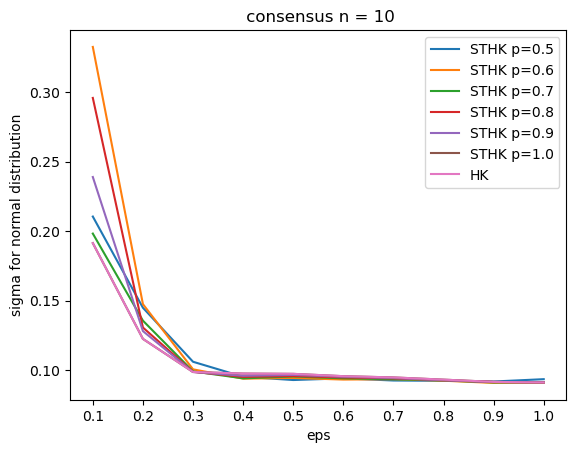

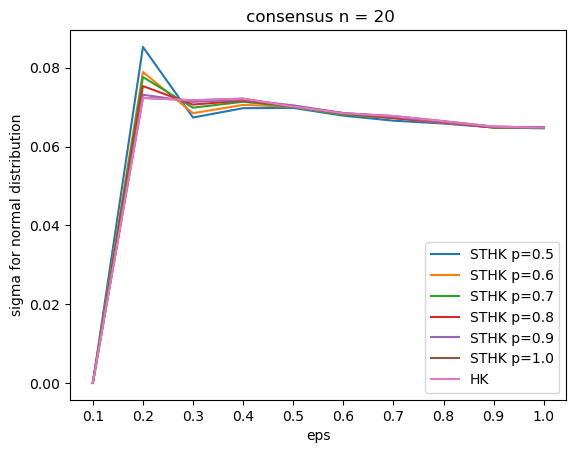

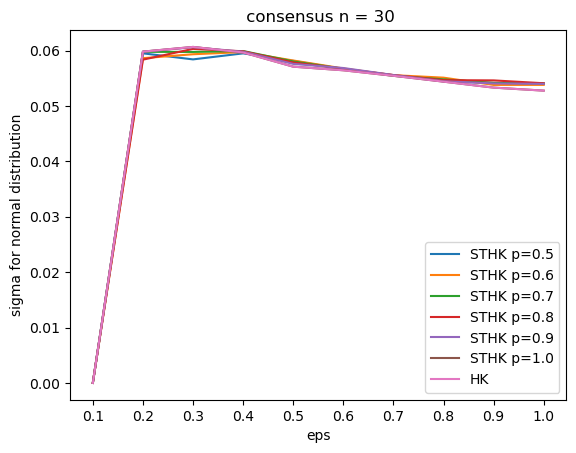

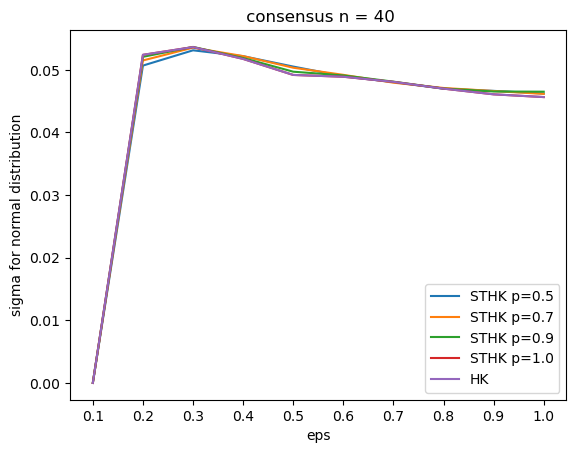

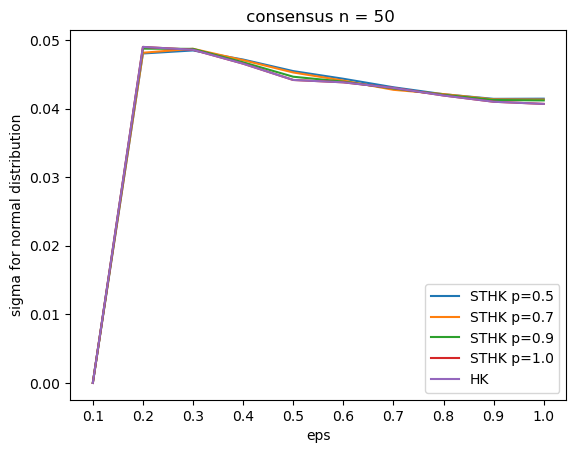

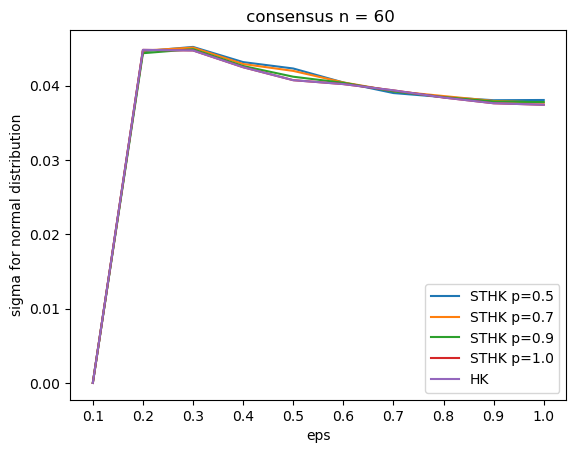

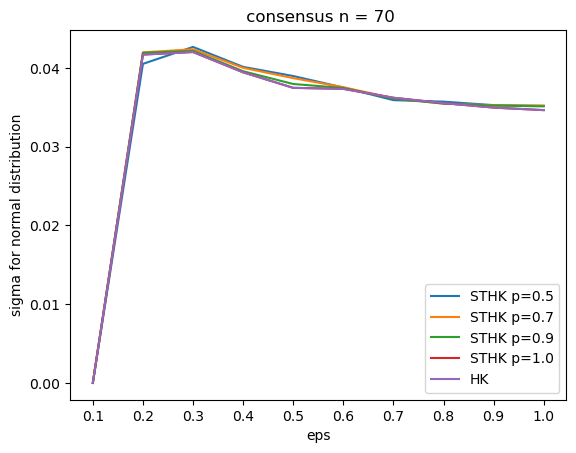

In [21]:
ee = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
pp = np.array([0.5,0.6, 0.7, 0.8, 0.9, 1.])
nn = np.array([10,20,30])
for n in nn:
    data = np.array([np.load(f'data/pcon{ee[i]}_{n}.npy', allow_pickle=True) for i in range(len(ee))])
    clv = data.copy()
    data = np.array([np.load(f'data/pccon{ee[i]}_{n}.npy', allow_pickle=True) for i in range(len(ee))], dtype=object)
    cclv = data.copy()

    sigmac=np.array([np.std(cclv[i]) for i in range(len(ee))])

    #print('HK', sigmac, sep='\n')

    for p in range (pp.shape[0]):
        sigmas=np.array([np.std(clv[i,p]) for i in range(len(ee))])
        plt.plot(ee, sigmas, label=f'STHK p={pp[p]}')
        #print(f'STHK p={pp[p]}', sigmas, sep='\n')
    plt.plot(ee, sigmac, label='HK')
    plt.xticks(ee)
    plt.xlabel('eps')
    plt.ylabel('sigma for normal distribution')
    plt.title(f' consensus n = {n}')
    plt.legend()

    plt.show()
pp = np.array([0.5, 0.7, 0.9, 1.])
nn = np.array([40, 50, 60, 70])
for n in nn:
    data = np.array([np.load(f'data/pcon{ee[i]}_{n}.npy', allow_pickle=True) for i in range(len(ee))])
    clv = data.copy()
    data = np.array([np.load(f'data/pccon{ee[i]}_{n}.npy', allow_pickle=True) for i in range(len(ee))], dtype=object)
    cclv = data.copy()

    sigmac=np.array([np.std(cclv[i]) for i in range(len(ee))])

    #print('HK', sigmac, sep='\n')

    for p in range (pp.shape[0]):
        sigmas=np.array([np.std(clv[i,p]) for i in range(len(ee))])
        plt.plot(ee, sigmas, label=f'STHK p={pp[p]}')
        #print(f'STHK p={pp[p]}', sigmas, sep='\n')
    plt.plot(ee, sigmac, label='HK')
    plt.xticks(ee)
    plt.xlabel('eps')
    plt.ylabel('sigma for normal distribution')
    plt.title(f' consensus n = {n}')
    plt.legend()

    plt.show()

HK
[0.19144372 0.12260786 0.09882715 0.09769892 0.09748346 0.09582615
 0.09492345 0.09333875 0.09171824 0.091332  ]


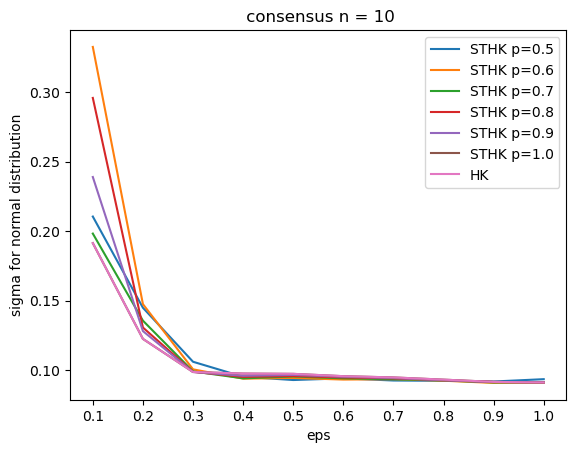

HK
[0.         0.07235216 0.07173145 0.07214612 0.07015058 0.06844228
 0.06773424 0.0664307  0.06505951 0.06480674]


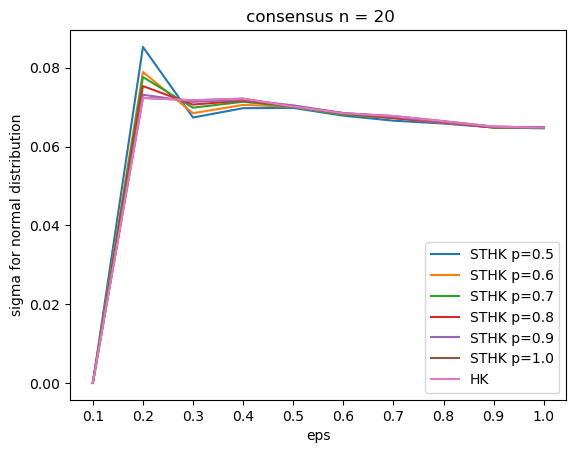

HK
[0.         0.05982262 0.06067137 0.05966878 0.05710619 0.05645358
 0.05545686 0.05440105 0.05332257 0.05277902]


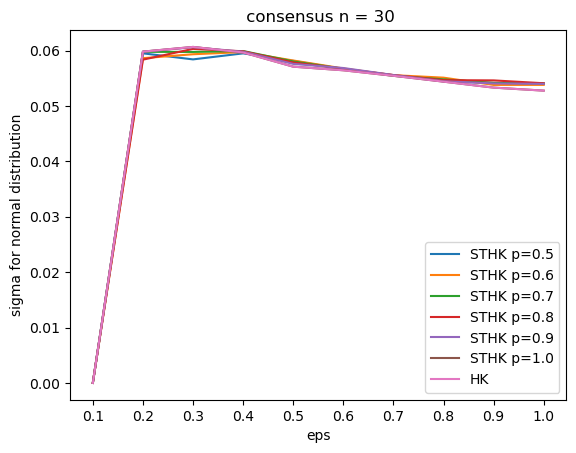

HK
[0.         0.05982262 0.06067137 0.05966878 0.05710619 0.05645358
 0.05545686 0.05440105 0.05332257 0.05277902]


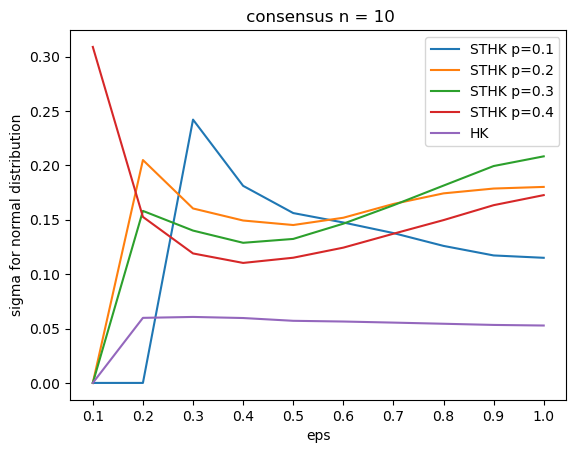

HK
[0.         0.05982262 0.06067137 0.05966878 0.05710619 0.05645358
 0.05545686 0.05440105 0.05332257 0.05277902]


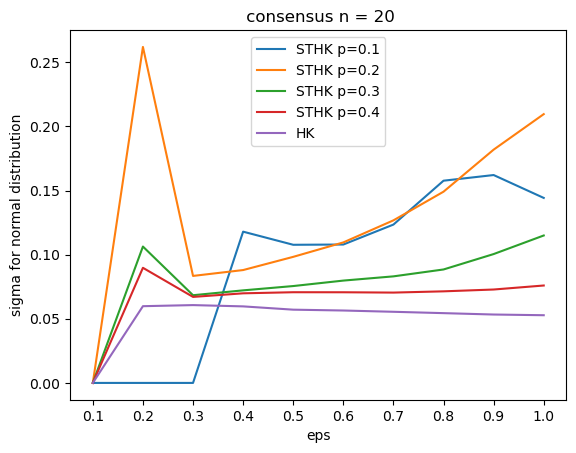

HK
[0.         0.05982262 0.06067137 0.05966878 0.05710619 0.05645358
 0.05545686 0.05440105 0.05332257 0.05277902]


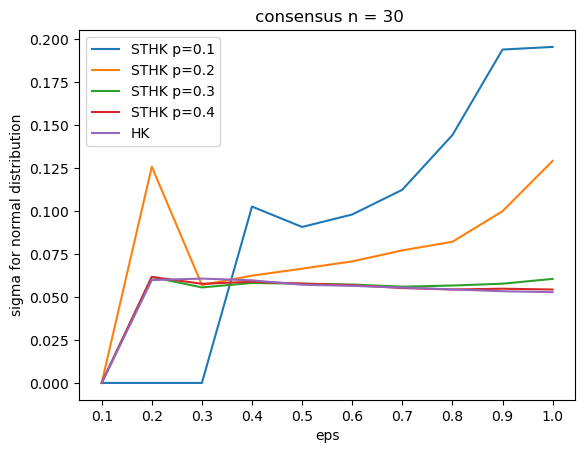

In [22]:
ee = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
pp = np.array([0.5,0.6, 0.7, 0.8, 0.9, 1.])
nn = np.array([10, 20, 30])
for n in nn:
    data = np.array([np.load(f'data/pcon{ee[i]}_{n}.npy', allow_pickle=True) for i in range(len(ee))])
    clv = data.copy()
    data = np.array([np.load(f'data/pccon{ee[i]}_{n}.npy', allow_pickle=True) for i in range(len(ee))], dtype=object)
    cclv = data.copy()

    sigmac=np.array([np.std(cclv[i]) for i in range(len(ee))])

    print('HK', sigmac, sep='\n')

    for p in range (pp.shape[0]):
        sigmas=np.array([np.std(clv[i,p]) for i in range(len(ee))])
        plt.plot(ee, sigmas, label=f'STHK p={pp[p]}')
        #print(f'STHK p={pp[p]}', sigmas, sep='\n')
    plt.plot(ee, sigmac, label='HK')
    plt.xticks(ee)
    plt.xlabel('eps')
    plt.ylabel('sigma for normal distribution')
    plt.title(f' consensus n = {n}')
    plt.legend()

    plt.show()
pp = np.array([0.1, 0.2, 0.3, 0.4])
nn = np.array([10, 20, 30])
for n in nn:
    data = np.array([np.load(f'data/ppcon{ee[i]}_{n}.npy', allow_pickle=True) for i in range(len(ee))])
    clv = data.copy()
    data = np.array([np.load(f'data/ppccon{ee[i]}_{n}.npy', allow_pickle=True) for i in range(len(ee))], dtype=object)
    cclv = data.copy()

    #sigmac=np.array([np.std(cclv[i]) for i in range(len(ee))])

    print('HK', sigmac, sep='\n')

    for p in range (pp.shape[0]):
        sigmas=np.array([np.std(clv[i,p]) for i in range(len(ee))])
        plt.plot(ee, sigmas, label=f'STHK p={pp[p]}')
        #print(f'STHK p={pp[p]}', sigmas, sep='\n')
    plt.plot(ee, sigmac, label='HK')
    plt.xticks(ee)
    plt.xlabel('eps')
    plt.ylabel('sigma for normal distribution')
    plt.title(f' consensus n = {n}')
    plt.legend()

    plt.show()

среднекв отклонение 0.04803896795000016, дисперсия 0.0023077424417011425, мат ожидание 0.4976989621410354


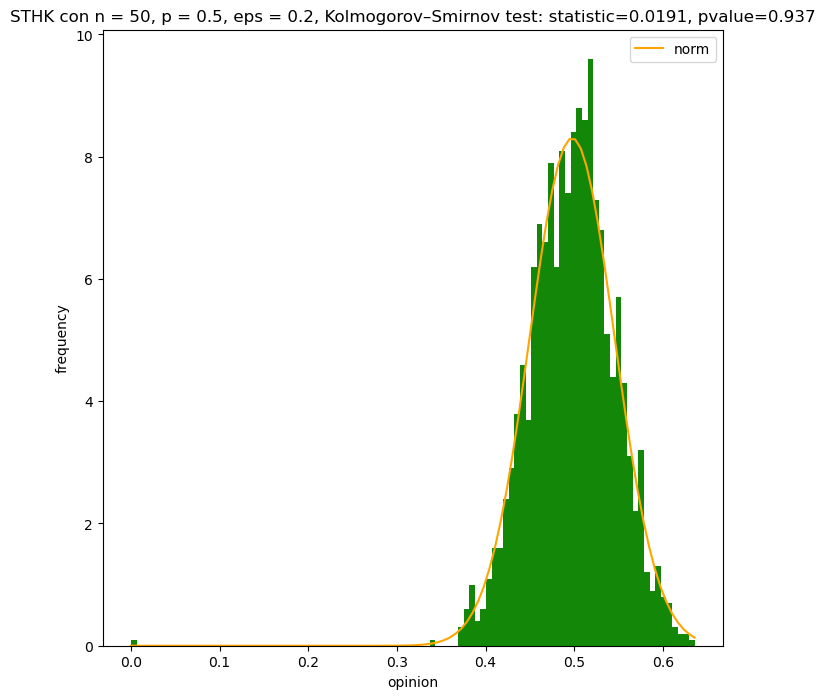

In [44]:
clv0250=np.load('data/pcon0.2_50.npy', allow_pickle=True)[0] #cl_rs[0, 0]
mu = np.mean(clv0250)
sigma = np.std(clv0250) 
print(f'среднекв отклонение {sigma}, дисперсия {sigma**2}, мат ожидание {mu}')

st, pv=stats.ks_2samp(stats.norm.rvs(mu,sigma, size=len(np.array(clv0250))),np.array(clv0250), mode='auto')
fig = plt.figure(facecolor='white', figsize=(8, 8))
hist = plt.hist(np.array(clv0250), density = True, bins=100, stacked = True, color = '#138808')
x = np.linspace(hist[1].min(), hist[1].max(), num=100)

plt.plot(x, stats.norm.pdf(x,mu,sigma), color ="orange", label='norm')
plt.xlabel('opinion')
plt.ylabel('frequency')
plt.title(f'STHK con n = 50, p = 0.5, eps = 0.2, Kolmogorov–Smirnov test: statistic={st:.3}, pvalue={pv:.3}')
plt.legend()

plt.show()

среднекв отклонение 0.04899466630728569, дисперсия 0.0024004773265622753, мат ожидание 0.49846907509903704


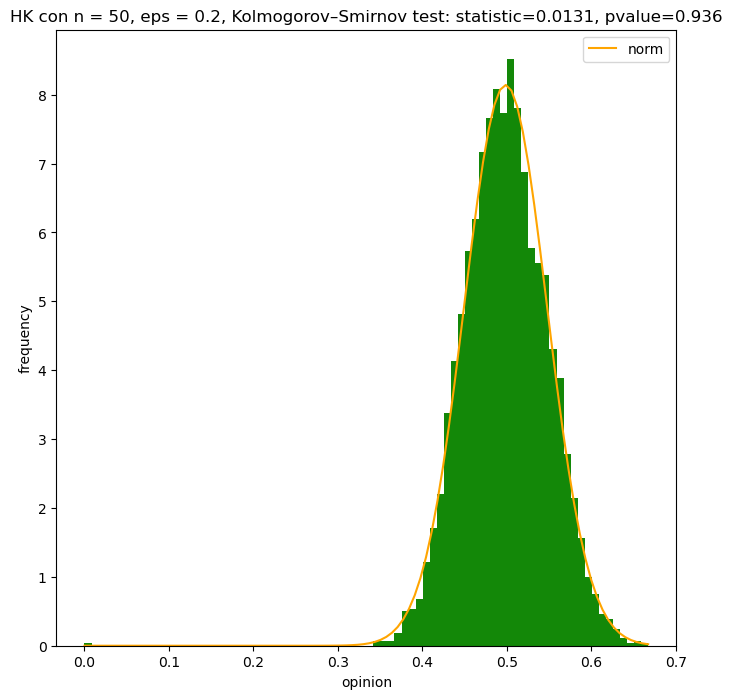

In [38]:
cclv0250=np.load('data/pccon0.2_50.npy', allow_pickle=True)
mu = np.mean(cclv0250)
sigma = np.std(cclv0250) 
print(f'среднекв отклонение {sigma}, дисперсия {sigma**2}, мат ожидание {mu}')

st, pv=stats.ks_2samp(stats.norm.rvs(mu,sigma, size=len(np.array(cclv0250))),np.array(cclv0250), mode='auto')
fig = plt.figure(facecolor='white', figsize=(8, 8))
hist = plt.hist(np.array(cclv0250), density = True, bins=80, stacked = True, color = '#138808')
x = np.linspace(hist[1].min(), hist[1].max(), num=100)

plt.plot(x, stats.norm.pdf(x,mu,sigma), color ="orange", label='norm')
plt.xlabel('opinion')
plt.ylabel('frequency')
plt.title(f'HK con n = 50, eps = 0.2, Kolmogorov–Smirnov test: statistic={st:.3}, pvalue={pv:.3}')
plt.legend()

plt.show()

среднекв отклонение 0.05277902008890891, дисперсия 0.0027856249615454505, мат ожидание 0.49982066159001404


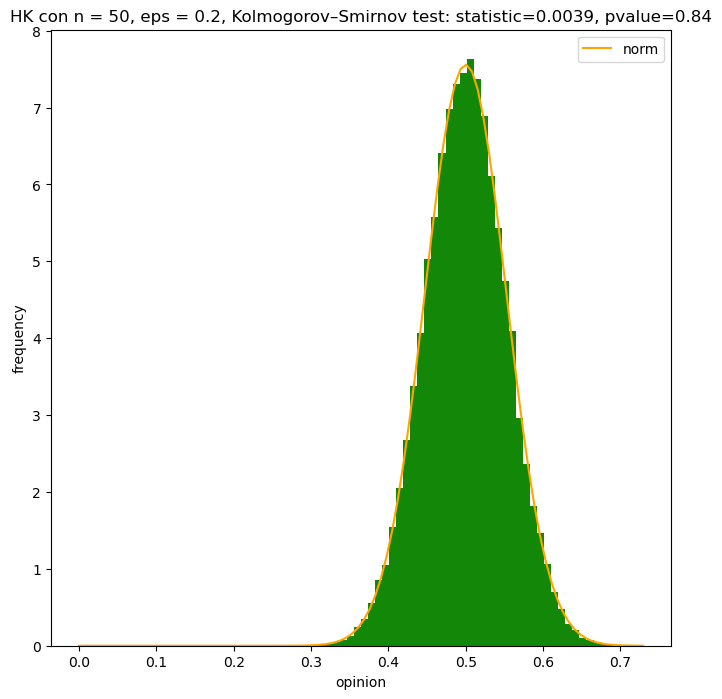

In [35]:
cclv0250=cl_rs_c[0]
mu = np.mean(cclv0250)
sigma = np.std(cclv0250) 
print(f'среднекв отклонение {sigma}, дисперсия {sigma**2}, мат ожидание {mu}')

st, pv=stats.ks_2samp(stats.norm.rvs(mu,sigma, size=len(np.array(cclv0250))),np.array(cclv0250), mode='auto')
fig = plt.figure(facecolor='white', figsize=(8, 8))
hist = plt.hist(np.array(cclv0250), density = True, bins=80, stacked = True, color = '#138808')
x = np.linspace(hist[1].min(), hist[1].max(), num=100)

plt.plot(x, stats.norm.pdf(x,mu,sigma), color ="orange", label='norm')
plt.xlabel('opinion')
plt.ylabel('frequency')
plt.title(f'HK con n = 50, eps = 0.2, Kolmogorov–Smirnov test: statistic={st:.3}, pvalue={pv:.3}')
plt.legend()

plt.show()